In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pystan
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [2]:
pjme = pd.read_csv('/Users/Asus/Documents/Atmel Studio/PJME_hourly.csv',index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

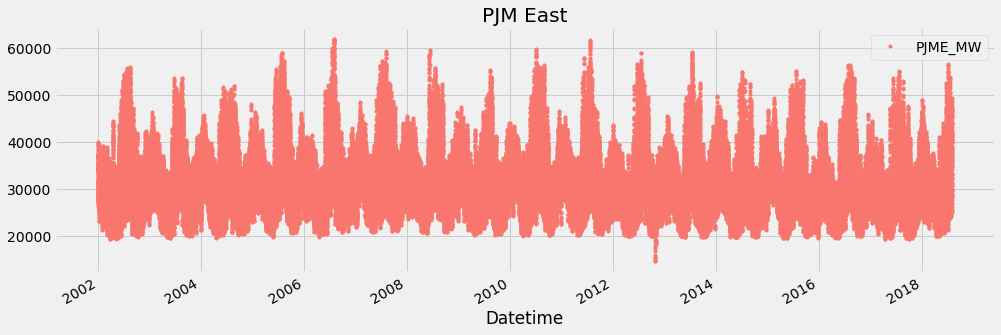

In [3]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

# EDA

We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.



In [4]:
 ## Creates time series features from datetime index.
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

<ipython-input-4-67c6f44fe6c7>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [5]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plotting the Features to see trends

Power demand has strong daily and seasonal properties.
Day of week also seems to show differences in peaks

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


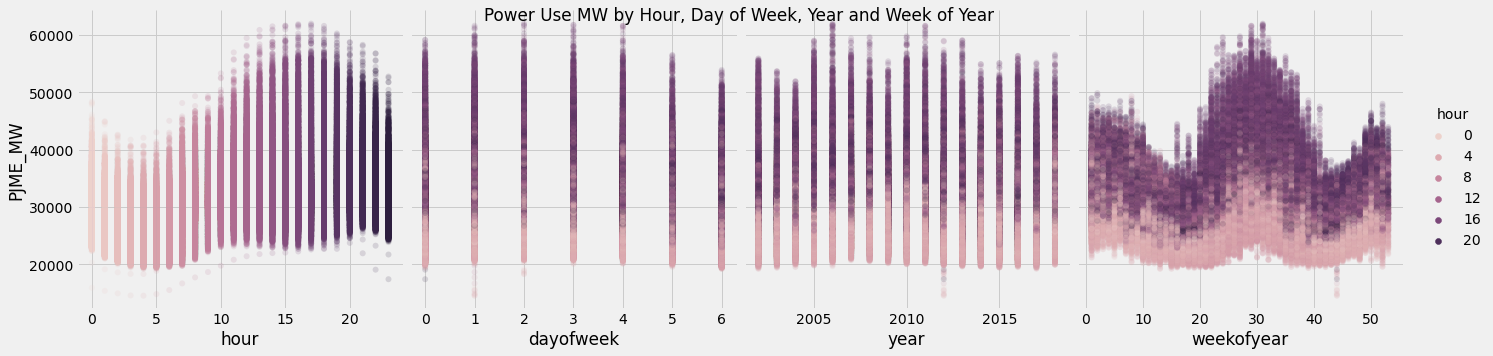

In [6]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

# Train/Test Split

Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

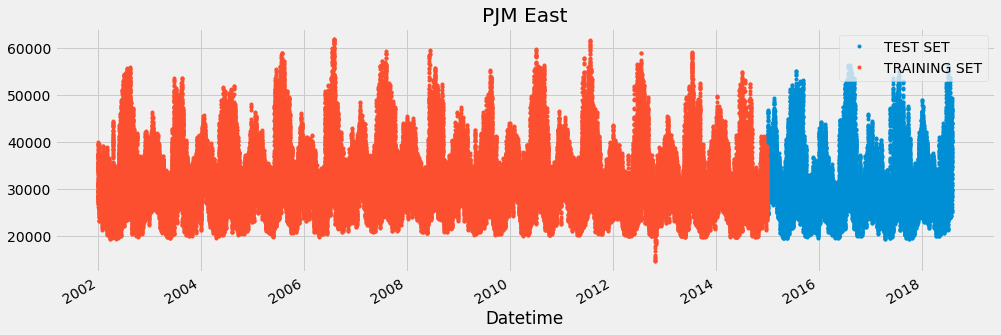

In [8]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

# Simple Prophet Model

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [9]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## Adding Holidays


Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

In [11]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'SriLankanGovHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,SriLankanGovHoliday
1,2002-12-25 01:00:00,SriLankanGovHoliday
2,2002-12-25 02:00:00,SriLankanGovHoliday
3,2002-12-25 03:00:00,SriLankanGovHoliday
4,2002-12-25 04:00:00,SriLankanGovHoliday


In [12]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

## Compare Models Just for Holiday Dates

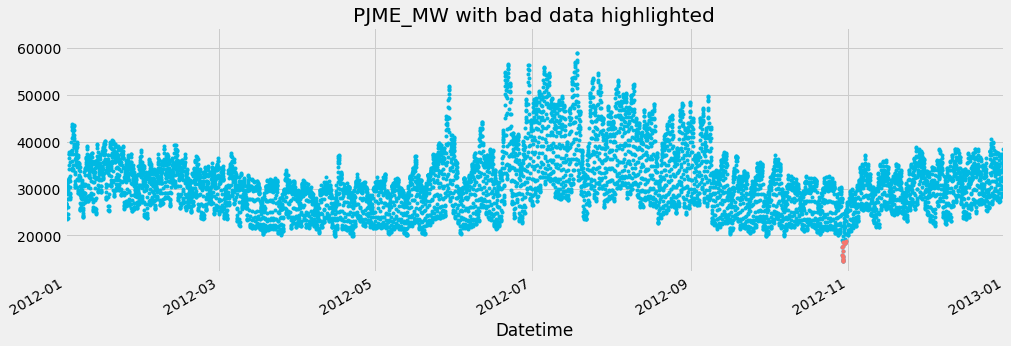

In [13]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

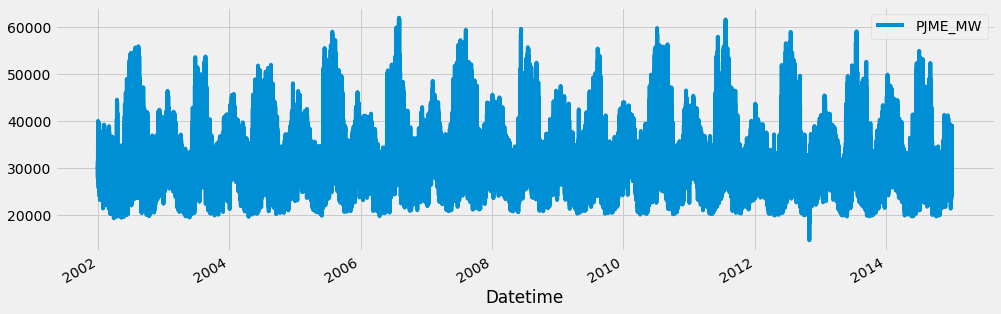

In [14]:
pjme_train.plot(figsize=(15, 5))
plt.show()

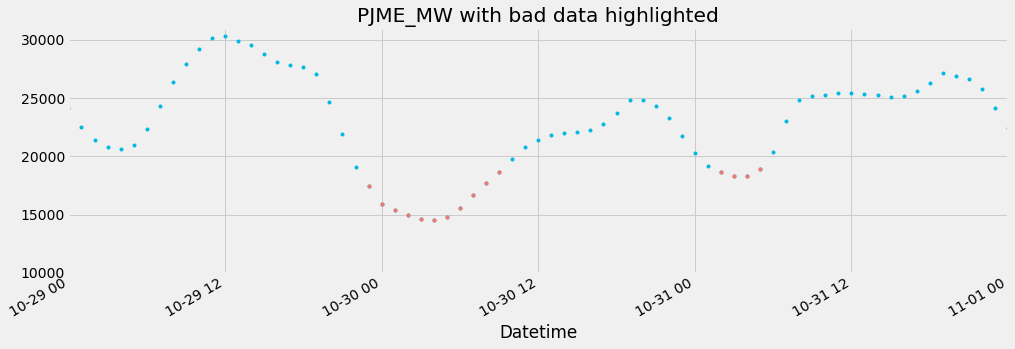

In [15]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('10-29-2012','11-01-2012'),
                     ylim=(10000, 31000)
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()